# Final training of convolutionnal neural networks (CNNs)

In this notebook, we train the CNNs such as AlexNet, VGG11, ... Our baseline is also trained in this notebook. The trained data is under amplitude and chi-square limitations. The CNNs are trained over a balanced dataset of 10 000 samples with a fraction of 85\% for the training.
The setting for the training are :
 * batch size : 64 
 * training size : 85\%

Final best results :

    * Baseline model
        Epoch : 20  
        Without rounding : AUCROC : 0.982
            AUROC Mass : 0.998 - AUROC Source : 0.965
        With rounding : AUCROC : 0.948
            AUROC Mass : 0.982 - AUROC Source : 0.913


## 0. Import

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import torch
from torch.utils.data import DataLoader
import torch.nn as nn


from helpers.data_generation.file_management import read_hdf5
from helpers.data_generation.error_generation_chi2 import Residual, CombineDataset
from helpers.model.helpers_model import NeuralNet
from helpers.plot.plot_roc import colorline
from sklearn.metrics import roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore') 

## 1. Preparating the dataset

In [5]:
size = 10000
ratio = 0.75; percent = np.array([0.005, 0.015, 0.005])


res = Residual()
res.build(size, ratio = ratio, per_error = percent)

print('Data Generation Finished')

Data Generation Finished


In [6]:
metadata = pd.DataFrame()
size = 10000
ratio = 0.75; percent = np.array([0.005, 0.015, 0.005])

str_ID =  "S"+str(size)+"R"+str(int(ratio*100))
[final_array, metadata] = read_hdf5(str_ID)
metadata ['ID'] = np.arange(0,final_array.shape[0])

data_set = CombineDataset(metadata,'ID','class',final_array, True)

data_train, data_test = train_test_split(data_set,train_size=0.85,random_state=42)

batch_size = 64; max_epoch = 30


loader_train = DataLoader(data_train, batch_size = batch_size, 
                          num_workers = 8, drop_last=True, pin_memory = True)
loader_test = DataLoader(data_test, batch_size = batch_size, 
                         num_workers = 8, drop_last=True, pin_memory = True)
print('Reading Data Finished')

Reading Data Finished


## 2. Convolutionnal neural network (CNN)
### 2.0 Baseline

Results :
* Baseline : 
    * Epoch : 20
    * Without Rounding - AUCROC mass : 0.998 - AUCROC source : 0.965
    * With Rounding - AUCROC mass : 0.982 - AUCROC source : 0.913


epoch: 19.000, auc: 0.941
Epoch : 19
epoch: 20.000, auc: 0.943
Epoch : 20
epoch: 21.000, auc: 0.943
Epoch : 21
epoch: 22.000, auc: 0.945
Epoch : 22
epoch: 23.000, auc: 0.947
Epoch : 23
Epoch : 24
epoch: 25.000, auc: 0.948
Epoch : 25
epoch: 26.000, auc: 0.949
Epoch : 26
Epoch : 27
Epoch : 28
Epoch : 29
Epoch : 30
Finished Training - Baseline


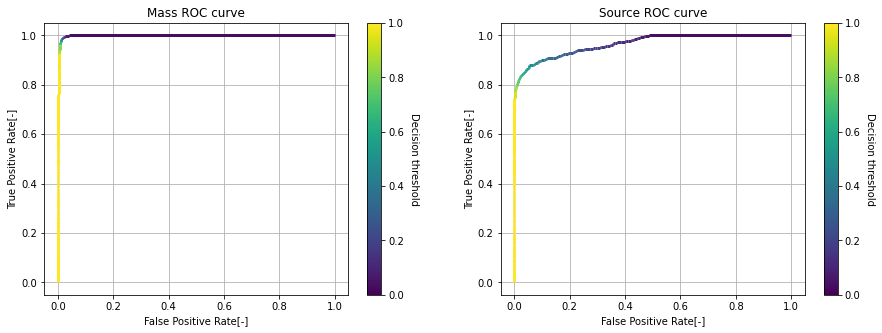

Epoch : 26
Without Rounding - ROC mass : 0.998 - ROC source : 0.967
With Rounding - ROC mass : 0.985 - ROC source : 0.912


In [7]:
netbasic = NeuralNet('BasicCNN', 'SGD/momentum')
netbasic.load_checkpoint('_current')
while len(netbasic.epoch_metric) < max_epoch:  # loop over the dataset multiple times
    netbasic.train(loader_train)
    res = netbasic.test(loader_test)
    print("Epoch : "+ str(netbasic.current_epoch))

print('Finished Training - Baseline')


netbasic.load_checkpoint('_optimal')
with torch.no_grad():
    predictions = []
    targets = []
    for data in loader_test:
        images, _, labels = data
        outputs = netbasic.net(images)

        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())
    predictions = np.array(predictions); targets = np.array(targets)
        
# calculate roc curves
ns_fpr, ns_tpr, ns_thres = roc_curve(targets[:,0], predictions[:,0])
lr_fpr, lr_tpr, lr_thres = roc_curve(targets[:,1], predictions[:,1])
# plot the roc curve for the model

plt.figure(figsize=(15,5))
plt.subplot(121)
lc = colorline(ns_fpr, ns_tpr, ns_thres, cmap=plt.get_cmap('viridis'))
plt.title('Mass ROC curve')
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()

plt.subplot(122)
lc = colorline(lr_fpr, lr_tpr,  lr_thres, cmap=plt.get_cmap('viridis'))
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.title('Source ROC curve')
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()
plt.savefig("figures/cnn/Baseline_roc.png")
# show the plot
plt.show()

print('Epoch :', len(netbasic.epoch_metric))
print('Without Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], predictions[:,0]), 
                                                                       roc_auc_score(targets[:,1], predictions[:,1])))
print('With Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], np.round(predictions[:,0])), 
                                                                       roc_auc_score(targets[:,1], np.round(predictions[:,1]))))


### 2.1. Spatial exploitation CNN

Results :
* AlexNet :  
    * Epoch : 50
    * Without Rounding - AUCROC mass : 0.998 - AUCROC source : 0.938
    * With Rounding - AUCROC mass : 0.979 - AUCROC source : 0.853

* VGG11 :  
    * Epoch : 16
    * Without Rounding - ROC mass : 0.999 - ROC source : 0.964
    * With Rounding - ROC mass : 0.986 - ROC source : 0.896

* GoogleNet :  
    * Epoch : 30
    * Without Rounding - ROC mass : 0.999 - ROC source : 0.946
    * With Rounding - ROC mass : 0.986 - ROC source : 0.854

#### AlexNet

Finished Training - AlexNet


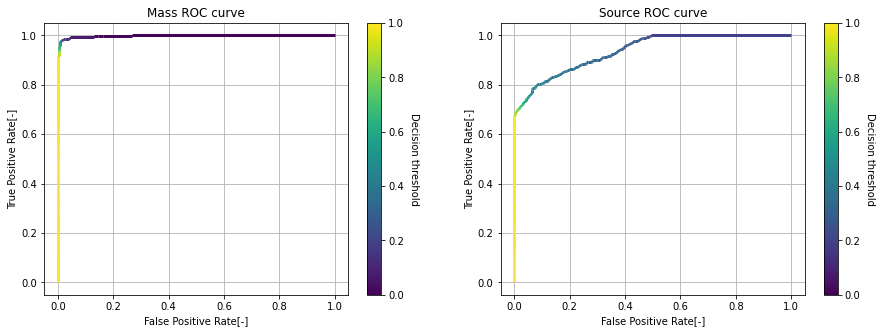

Epoch : 50
Without Rounding - ROC mass : 0.998 - ROC source : 0.938
With Rounding - ROC mass : 0.979 - ROC source : 0.853


In [8]:
netbasic = NeuralNet('AlexNet', 'SGD/momentum')
netbasic.load_checkpoint('_current')
while len(netbasic.epoch_metric) < max_epoch:
    netbasic.train(loader_train)
    res = netbasic.test(loader_test)
    print("Epoch : ", len(netbasic.epoch_metric))
    
print('Finished Training - AlexNet')

netbasic.load_checkpoint('_optimal')
with torch.no_grad():
    predictions = []
    targets = []
    for data in loader_test:
        images, _, labels = data
        m = nn.ZeroPad2d(80)
        outputs = netbasic.net(m(images))

        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())
    predictions = np.array(predictions); targets = np.array(targets)
        
# calculate roc curves
ns_fpr, ns_tpr, ns_thres = roc_curve(targets[:,0], predictions[:,0])
lr_fpr, lr_tpr, lr_thres = roc_curve(targets[:,1], predictions[:,1])
# plot the roc curve for the model

plt.figure(figsize=(15,5))
plt.subplot(121)
lc = colorline(ns_fpr, ns_tpr, ns_thres, cmap=plt.get_cmap('viridis'))
plt.title('Mass ROC curve')
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()

plt.subplot(122)
lc = colorline(lr_fpr, lr_tpr,  lr_thres, cmap=plt.get_cmap('viridis'))
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.title('Source ROC curve')
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()
plt.savefig("figures/cnn/AlexNet_roc.png")
# show the plot
plt.show()

print('Epoch :', len(netbasic.epoch_metric))
print('Without Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], predictions[:,0]), 
                                                                       roc_auc_score(targets[:,1], predictions[:,1])))
print('With Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], np.round(predictions[:,0])), 
                                                                       roc_auc_score(targets[:,1], np.round(predictions[:,1]))))


#### VGG11

Finished Training - VGG11


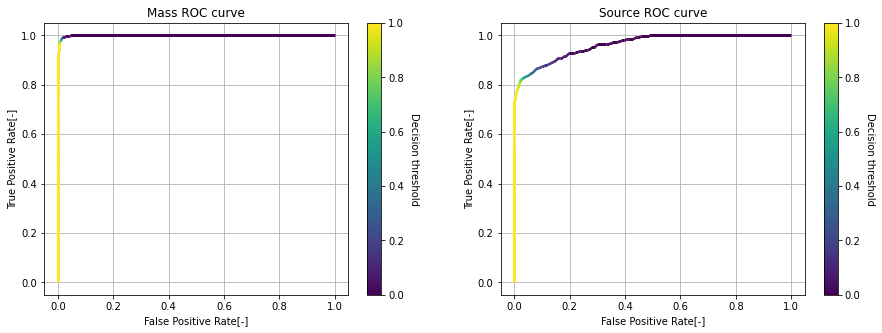

Epoch : 16
Without Rounding - ROC mass : 0.999 - ROC source : 0.964
With Rounding - ROC mass : 0.986 - ROC source : 0.896


In [9]:
test_acc = np.zeros(max_epoch); 
netbasic = NeuralNet('VGG11', 'Adam')
netbasic.load_checkpoint('_current')

while len(netbasic.epoch_metric) < max_epoch:
    netbasic.train(loader_train, resize_tp = 'Padding')
    res = netbasic.test(loader_test)
    print("Epoch : ", len(netbasic.epoch_metric))
    
print('Finished Training - VGG11')

netbasic.load_checkpoint('_optimal')
with torch.no_grad():
    predictions = []
    targets = []
    for data in loader_test:
        images, _, labels = data
        m = nn.ZeroPad2d(80)
        outputs = netbasic.net(m(images))

        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())
    predictions = np.array(predictions); targets = np.array(targets)
        
# calculate roc curves
ns_fpr, ns_tpr, ns_thres = roc_curve(targets[:,0], predictions[:,0])
lr_fpr, lr_tpr, lr_thres = roc_curve(targets[:,1], predictions[:,1])
# plot the roc curve for the model

plt.figure(figsize=(15,5))
plt.subplot(121)
lc = colorline(ns_fpr, ns_tpr, ns_thres, cmap=plt.get_cmap('viridis'))
plt.title('Mass ROC curve')
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()

plt.subplot(122)
lc = colorline(lr_fpr, lr_tpr,  lr_thres, cmap=plt.get_cmap('viridis'))
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.title('Source ROC curve')
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()
plt.savefig("figures/cnn/VGG11_roc.png")
# show the plot
plt.show()

print('Epoch :', len(netbasic.epoch_metric))
print('Without Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], predictions[:,0]), 
                                                                       roc_auc_score(targets[:,1], predictions[:,1])))
print('With Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], np.round(predictions[:,0])), 
                                                                       roc_auc_score(targets[:,1], np.round(predictions[:,1]))))


#### GoogleNet

Finished Training - GoogleNet


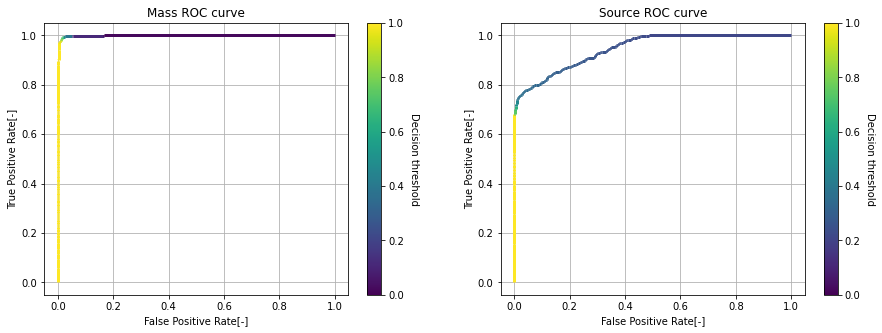

Epoch : 30
Without Rounding - ROC mass : 0.999 - ROC source : 0.946
With Rounding - ROC mass : 0.986 - ROC source : 0.854


In [10]:
netbasic = NeuralNet('GoogleNet', 'SGD/momentum')
netbasic.load_checkpoint('_current')
while len(netbasic.epoch_metric) < max_epoch:
    netbasic.train(loader_train, resize_tp = 'Padding')
    res = netbasic.test(loader_test)

print('Finished Training - GoogleNet')
    
netbasic.load_checkpoint('_optimal')
with torch.no_grad():
    predictions = []
    targets = []
    for data in loader_test:
        images, _, labels = data
        m = nn.ZeroPad2d(80)
        outputs, _, _ = netbasic.net(m(images))

        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())
    predictions = np.array(predictions); targets = np.array(targets)
        
        
# calculate roc curves
ns_fpr, ns_tpr, ns_thres = roc_curve(targets[:,0], predictions[:,0])
lr_fpr, lr_tpr, lr_thres = roc_curve(targets[:,1], predictions[:,1])
# plot the roc curve for the model

plt.figure(figsize=(15,5))
plt.subplot(121)
lc = colorline(ns_fpr, ns_tpr, ns_thres, cmap=plt.get_cmap('viridis'))
plt.title('Mass ROC curve')
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()

plt.subplot(122)
lc = colorline(lr_fpr, lr_tpr,  lr_thres, cmap=plt.get_cmap('viridis'))
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.title('Source ROC curve')
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()
plt.savefig("figures/cnn/GoogleNet_roc.png")
# show the plot
plt.show()

print('Epoch :', len(netbasic.epoch_metric))
print('Without Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], predictions[:,0]), 
                                                                       roc_auc_score(targets[:,1], predictions[:,1])))
print('With Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], np.round(predictions[:,0])), 
                                                                       roc_auc_score(targets[:,1], np.round(predictions[:,1]))))


### 2.2. Multi-path exploitation CNN

Results :
* ResNet18 :  
    * Epoch : 39
    * Without Rounding - ROC mass : 0.999 - ROC source : 0.961
    * With Rounding - ROC mass : 0.983 - ROC source : 0.89
* DenseNet121 :  
    * Epoch : 21 - AUCROC : 0.940
    * Without Rounding - ROC mass : 0.998 - ROC source : 0.959
    * With Rounding - ROC mass : 0.986 - ROC source : 0.894

#### ResNet18

Finished Training - ResNet18


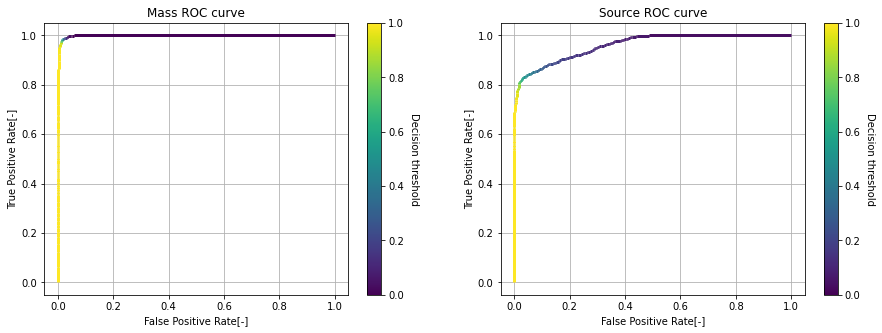

Epoch : 39
Without Rounding - ROC mass : 0.999 - ROC source : 0.961
With Rounding - ROC mass : 0.983 - ROC source : 0.897


In [11]:
netbasic = NeuralNet('ResNet18', 'SGD/momentum')
netbasic.load_checkpoint('_current')
while len(netbasic.epoch_metric) < max_epoch:
    netbasic.train(loader_train)
    res = netbasic.test(loader_test)
    print("Epoch: ", len(netbasic.epoch_metric))

print('Finished Training - ResNet18')

netbasic.load_checkpoint('_optimal')
with torch.no_grad():
    predictions = []
    targets = []
    for data in loader_test:
        images, _, labels = data
        m = nn.ZeroPad2d(80)
        outputs = netbasic.net(m(images))

        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())
    predictions = np.array(predictions); targets = np.array(targets)
        
        
# calculate roc curves
ns_fpr, ns_tpr, ns_thres = roc_curve(targets[:,0], predictions[:,0])
lr_fpr, lr_tpr, lr_thres = roc_curve(targets[:,1], predictions[:,1])
# plot the roc curve for the model

plt.figure(figsize=(15,5))
plt.subplot(121)
lc = colorline(ns_fpr, ns_tpr, ns_thres, cmap=plt.get_cmap('viridis'))
plt.title('Mass ROC curve')
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()

plt.subplot(122)
lc = colorline(lr_fpr, lr_tpr,  lr_thres, cmap=plt.get_cmap('viridis'))
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.title('Source ROC curve')
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()
plt.savefig("figures/cnn/ResNet18_roc.png")
# show the plot
plt.show()

print('Epoch :', len(netbasic.epoch_metric))
print('Without Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], predictions[:,0]), 
                                                                       roc_auc_score(targets[:,1], predictions[:,1])))
print('With Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], np.round(predictions[:,0])), 
                                                                       roc_auc_score(targets[:,1], np.round(predictions[:,1]))))


#### DenseNet121

Finished Training - DenseNet121


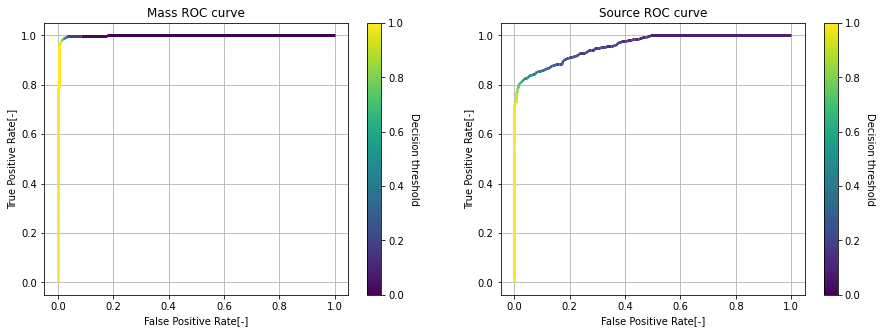

Epoch : 21
Without Rounding - ROC mass : 0.998 - ROC source : 0.959
With Rounding - ROC mass : 0.986 - ROC source : 0.894


In [12]:
netbasic = NeuralNet('DenseNet121', 'Adam')
netbasic.load_checkpoint('_current')
while len(netbasic.epoch_metric) < max_epoch:
    netbasic.train(loader_train, resize_tp = 'Padding')
    res = netbasic.test(loader_test)
    print("Epoch: ", len(netbasic.epoch_metric))

print('Finished Training - DenseNet121')

netbasic.load_checkpoint('_optimal')
with torch.no_grad():
    predictions = []
    targets = []
    for data in loader_test:
        images, _, labels = data
        m = nn.ZeroPad2d(80)
        outputs = netbasic.net(m(images))

        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())
    predictions = np.array(predictions); targets = np.array(targets)
        
# calculate roc curves
ns_fpr, ns_tpr, ns_thres = roc_curve(targets[:,0], predictions[:,0])
lr_fpr, lr_tpr, lr_thres = roc_curve(targets[:,1], predictions[:,1])
# plot the roc curve for the model

plt.figure(figsize=(15,5))
plt.subplot(121)
lc = colorline(ns_fpr, ns_tpr, ns_thres, cmap=plt.get_cmap('viridis'))
plt.title('Mass ROC curve')
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()

plt.subplot(122)
lc = colorline(lr_fpr, lr_tpr,  lr_thres, cmap=plt.get_cmap('viridis'))
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.title('Source ROC curve')
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()
plt.savefig("figures/cnn/DenseNet121_roc.png")
# show the plot
plt.show()

print('Epoch :', len(netbasic.epoch_metric))
print('Without Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], predictions[:,0]), 
                                                                       roc_auc_score(targets[:,1], predictions[:,1])))
print('With Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], np.round(predictions[:,0])), 
                                                                       roc_auc_score(targets[:,1], np.round(predictions[:,1]))))


### 2.3. Ressource limited CNNs
Result :
* SqueezeNet :  
    * Epoch : 50
    * Without Rounding - ROC mass : 0.954 - ROC source : 0.879
    * With Rounding - ROC mass : 0.947 - ROC source : 0.827

#### SqueezeNet

Finished Training - SqueezeNet


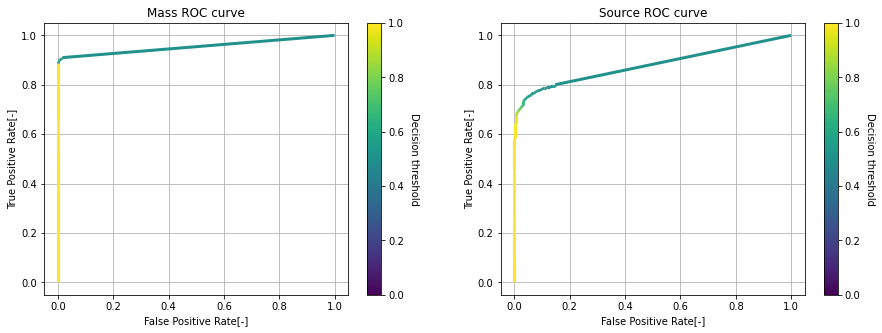

Epoch : 50
Without Rounding - ROC mass : 0.954 - ROC source : 0.879
With Rounding - ROC mass : 0.947 - ROC source : 0.827


In [13]:
netbasic = NeuralNet('SqueezeNet', 'Adam')
netbasic.load_checkpoint('_current')
while len(netbasic.epoch_metric) < max_epoch:
    netbasic.train(loader_train, resize_tp = 'Padding')
    res = netbasic.test(loader_test)
    print("Epoch: ", len(netbasic.epoch_metric))

print('Finished Training - SqueezeNet')
    
with torch.no_grad():
    predictions = []
    targets = []
    for data in loader_test:
        images, _, labels = data
        m = nn.ZeroPad2d(80)
        outputs = netbasic.net(m(images))

        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())
    predictions = np.array(predictions); targets = np.array(targets)
        
from sklearn.metrics import roc_curve, roc_auc_score
# calculate roc curves
ns_fpr, ns_tpr, ns_thres = roc_curve(targets[:,0], predictions[:,0])
lr_fpr, lr_tpr, lr_thres = roc_curve(targets[:,1], predictions[:,1])
# plot the roc curve for the model

plt.figure(figsize=(15,5))
plt.subplot(121)
lc = colorline(ns_fpr, ns_tpr, ns_thres, cmap=plt.get_cmap('viridis'))
plt.title('Mass ROC curve')
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()

plt.subplot(122)
lc = colorline(lr_fpr, lr_tpr,  lr_thres, cmap=plt.get_cmap('viridis'))
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.title('Source ROC curve')
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()
plt.savefig("figures/cnn/SqueezeNet_roc.png")
# show the plot
plt.show()

print('Epoch :', len(netbasic.epoch_metric))
print('Without Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], predictions[:,0]), 
                                                                       roc_auc_score(targets[:,1], predictions[:,1])))
print('With Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(targets[:,0], np.round(predictions[:,0])), 
                                                                       roc_auc_score(targets[:,1], np.round(predictions[:,1]))))


## 3. Training plot

Learning rate of each neural network with rounding such that $p \in \{0,1\}$.

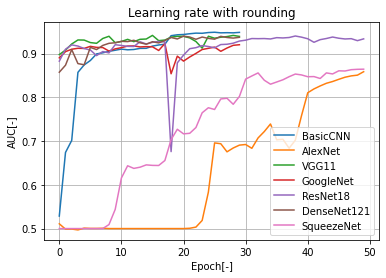

In [14]:
model_list = ['BasicCNN', 'AlexNet', 'VGG11', 'GoogleNet', 'ResNet18', 'DenseNet121', 'SqueezeNet']

plt.figure()
for model_name in model_list:
    netbasic = NeuralNet(model_name, 'SGD/momentum')
    netbasic.load_checkpoint('_current')
    plt.plot(netbasic.epoch_metric, label = model_name)

plt.xlabel('Epoch[-]')
plt.ylabel('AUC[-]')
# show the legend
plt.legend()
plt.grid()
plt.title('Learning rate with rounding')
plt.savefig("figures/cnn/Learning_rate.png")
plt.show()